# Customer segmentation using clustering an classification (Complicated)

https://archive.ics.uci.edu/ml/datasets/online+retail : 

이 데이터는 2010년 1월 20일 부터 2011년 9월 12일 까지의 기간동안 온라인 전자상거래 회사에서 발생한 transaction에 대한 내용이다. 해당 회사는 UK-based non-store online E-Commerce 회사이다.

이 데이터를 이용하여, 사용자의 행동을 분석한다. 분석한 결과를 이용해, 사용자의 행동을 예측하는 모델을 만들어보자.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, nltk 
import matplotlib.cm as cm
import itertools

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

# Plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

# 1. 데이터 로딩 
- feature 설명

In [4]:
# 유럽 데이터이기 때문에 인코딩을 다음과 같이 함.
df_initial = pd.read_csv('./inputs/e-commerce-data.csv', 
                         encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial.head()

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# 2. 데이터 전처리 (EDA 전, missing value 처리 등)

In [5]:
# InvoiceDate를 datetime 데이터 형태로 변형. (나중 연산을 위하여)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})

In [7]:
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object


In [8]:
tab_info.T.rename(index={0:'column type'})

,column type
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,object
Country,object


In [9]:
# Null value의 카운트와 비율을 체크합니다.
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.
                         rename(index={0:'null values (cnt)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0] *100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (cnt),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


#### CustomerID 25%의 결측치는 양이 너무 많습니다. 이 결측치의 값을 채워넣기보다는 제거하는 편이 낫습니다.

In [10]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (406829, 8)


In [11]:
# Null value를 제거한 후, 다시 한 번 null 값의 존재 유무를 체크합니다.
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.
                         rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [12]:
print('겹쳐지는 샘플의 수: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

겹쳐지는 샘플의 수: 5225


- 전처리
    - Datetime화
    - Null value 처리 (CustomerID 25% 제거)


# 3. EDA 및 mining

- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides.

## 3.1 Country

각 나라에서 발생한 고유한 transaction에 대한 count를 구합니다.

In [13]:
#customerID로 먼저 묶고, 그다음은 Invoice, 나라 로 묶어준다.
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
temp.head()

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland


In [14]:
# Transaction count에 대한 국가별 분포
countries = temp['Country'].value_counts()
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
Iceland                     7
USA                         7
Greece                      6
Canada                      6
Israel                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

Plotly를 활용한 시각화

In [15]:
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', 
            z = countries,
            text = countries.index, 
            colorbar = {'title':'Order nb.'},
            colorscale=[[0, 'rgb(224,255,255)'],
                        [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                        [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                        [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                        [1, 'rgb(227,26,28)']],    
            reversescale = False)

layout = dict(title='Number of orders per country',geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## 3.2 Customers and products



Users의 수와 products의 수를 알아보겠습니다.

In [16]:
df_initial.shape

(401604, 8)

In [17]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], 
             columns = ['products', 'transactions', 'customers'], 
             index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [18]:
# 특정 유저의 transaction 이력
df_initial[df_initial.InvoiceNo == '581180']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
535004,581180,23497,CLASSIC CHROME BICYCLE BELL,12,2011-12-07 15:52:00,1.45,12347,Iceland
535005,581180,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-07 15:52:00,2.08,12347,Iceland
535006,581180,21064,BOOM BOX SPEAKER BOYS,24,2011-12-07 15:52:00,1.25,12347,Iceland
535007,581180,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-12-07 15:52:00,0.85,12347,Iceland
535008,581180,21731,RED TOADSTOOL LED NIGHT LIGHT,24,2011-12-07 15:52:00,1.65,12347,Iceland
535009,581180,23084,RABBIT NIGHT LIGHT,24,2011-12-07 15:52:00,1.79,12347,Iceland
535010,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,12347,Iceland
535011,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,12347,Iceland
535012,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,12347,Iceland
535013,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,12347,Iceland


#### 개별 Transaction에서 구입한 각기 다른 Item의 수를 구해본다.
- groupby 이용 (invoiceNo)

In [19]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.sort_values('CustomerID').head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [20]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.sort_values('CustomerID').head(20)

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
12,12348,568172,3


해당 정보를 이용하여 얻을 수 있는 것들 :
- **InvoiceNo**에 C가 붙어있음을 통해서, 해당 transaction이 취소된 것을 알 수 있다. --> 취소내역 정리
- 1개만 구입한 사용자가 존재하는 것을 알 수 있다. (ex, 12346)
- 각 transaction에서 많은 items를 주문한 사용자가 있음을 알 수 있다. (ex, 12347)

## 3.3 Cancelling orders

Cancel order에 대한 transaction

In [21]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [22]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print(n1/n2 * 100)

16.466876971608833


In [23]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('취소된 주문의 비율(총 주문 건수 / 취소 건수): {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

취소된 주문의 비율(총 주문 건수 / 취소 건수): 3654/22190 (16.47%) 


취소 비율이 16%이면 높은 편입니다.

In [24]:
df_initial.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


취소내역과, 구입 내역이 1:1인지를 확인.(안 맞는 부분)  
(Quantity를 보면 -1이 곱해지는 것을 볼 수 있다.)  
#### 예외발생 : __2010년 1월 이전__에 구입한 상품에 대한 취소 건수, 이 데이터는 2010년 1월 ~ 2011년 9월 까지의 데이터 (취소만 있는 것은 어떤 건지 예측 가능)

In [25]:
#quantity -1곱해진 것 갖고 오기
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]

In [26]:
df_check.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29


In [27]:
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0])& (df_initial['Quantity'] == -col[1]) & 
                 (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


#### Discount의 경우가 발생
- Discount의 경우만 빼면 된다

In [28]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice','InvoiceDate']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
InvoiceDate                2010-12-01 09:49:00
Name: 154, dtype: object


In [29]:
# 바로 이 경우가 예측 가능한 경우. 즉 이전의 구매목록이 없고 취소 내역만 있는 경우.
df_initial[(df_initial['CustomerID'] == '15311')
           & (df_initial['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


In [30]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df_check.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': 
        continue  
    # 구매시기가 취소시기보다 먼저여야 합니다.
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity'] > 0)].copy()
    # 구입 transaction이 없는 취소
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    # 구입 transaction이 있는 취소
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    # 취소 transaction보다 구매 transaction의 수가 큰 경우
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: 
                continue
            # 취소 transaction보다 수량이 더 많은 구매 transaction이 있으면 빼준다.
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [31]:
df_cleaned.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,0


In [33]:
df_cleaned = df_initial.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode'] == col['StockCode'])&
                         (df_initial['InvoiceDate'] < col['InvoiceDate'])&
                         (df_initial['Quantity'] > 0)].copy()
    if (df_test.shape[0] ==0):
        doubtfull_entry.append(index)
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

- `entry_to_remove` : 대응되는 구입 transaction이 없는 취소 내역
- `doubtfull_entry` : 대응되는 구입 transaction이 있는 취소 내역(단, 같은 quantity가 최소한 1개 이상 있는)

In [34]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


취소 내역은 모두 삭제

In [35]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

df_cleaned.shape

(392857, 9)

541909 --> 392857

## 3.4 StockCode

**StockCode** 는 D(discount) 및 문자, 그리고 숫자형 데이터를 모두 포함하고 있다. 문자로 이루어진 경우를 찾아보자.

In [36]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [37]:
for code in list_special_codes:
    print("{:<15} : {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            : POSTAGE                       
D               : Discount                      
C2              : CARRIAGE                      
M               : Manual                        
BANK CHARGES    : Bank Charges                  
PADS            : PADS TO MATCH ALL CUSHIONS    
DOT             : DOTCOM POSTAGE                


In [38]:
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [39]:
for code in list_special_codes:
    print("{:<15} : {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            : POSTAGE                       
D               : Discount                      
C2              : CARRIAGE                      
M               : Manual                        
BANK CHARGES    : Bank Charges                  
PADS            : PADS TO MATCH ALL CUSHIONS    
DOT             : DOTCOM POSTAGE                


## 3.5 Basket Price
가격에 대해서 mining을 합니다. 한 번의 transaction에서 Customer가 구매한 상품들에 대한 전체 price를 계산한다.

먼저, 각 StockCode에 대한 Total price 변수를 생성하겠습니다.

In [40]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Transaction에 대한 basket price 변수를 생성한다.

In [41]:
# Basket price
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price.head()

,CustomerID,InvoiceNo,Basket Price
0,12346,541431,0.00
1,12347,537626,711.79
2,12347,542237,475.39
3,12347,549222,636.25
4,12347,556201,382.52


- 평균 구매 일시를 구해봄

In [42]:
# 1번의 transaction에서의 평균 구매 일시(average of invoice date)를 구한다.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,0.00,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256


In [43]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')

In [44]:
# Basket price가 0보다 큰 경우만 선택합니다.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID').head()

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


#### Basket price의 range를 나누자. ==> 시각화를 통해 인사이트 얻기

In [45]:
#price range는 임의로 선택
#price range안에 몇개가 있는지
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    print(val)
    count_price.append(val)

1142
1063
4001
8084
2830
1157
108


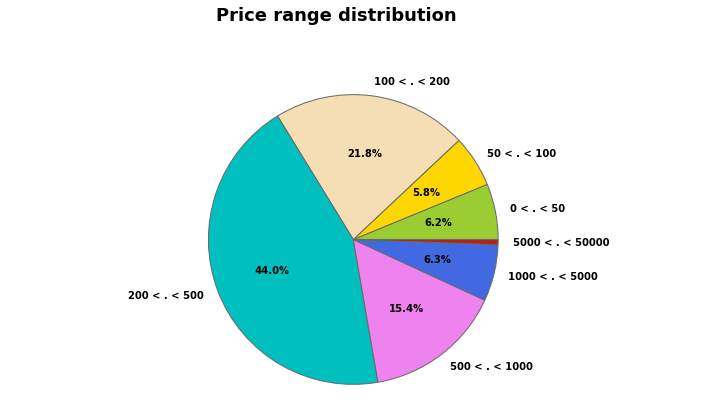

In [46]:
#총 구매 비용에 따라 나눠봄
plt.rc('font', weight='bold')

f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{} < . < {}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes,  labels=labels, colors = colors, #explode = explode
       autopct = lambda x:'{:.1f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Price range distribution ", ha='center', fontsize = 18);

#### 65% 정도의 고객(실제 거래를 한)이 200유로 이상의 돈을 사용하고 있다.

## 3.6 Product categories
- 가진 데이터에는 상품 카테고리 정보가 없다!
- **Description** 를 이용하여 product별 category를 만들어 보겠습니다.

___
>**NLTK**  
    품사 및 pos tagging : https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/

---

### 3.6.1 Products Description
- `keywords`: Description에서 추출된 모든 단어들
- `keywords_roots`: 어근(root)와 root와 association된 단어들
- `count_keywords`: 단어가 몇 번 나왔는지를 체크

In [47]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe):
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots = dict()
    keyworkd_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    for s in dataframe['Description']:
        if pd.isnull(s):continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t) #어근 추출
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else :
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    for s in keywords_roots.keys():
        if len(keywords_roots[s])>1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else :
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[2] = list(keywords_roots[s])[0]
            
    print("Number of keywords in variable '{}': {}".format('Description', len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [48]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # 어근
    keywords_select = dict()  # 어근과 연결된 단어들
    category_keys   = []  # 몇 개의 category key가 있는지 체크하기 위하여
    count_keywords  = dict()
    icount = 0
    for s in dataframe['Description']:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef  # 어근 찾기 (가장 짧음)
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format('Description', len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [49]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [50]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in variable 'Description': 1483


In [51]:
keywords[:10]

['heart',
 'holder',
 'metal',
 'lantern',
 'cream',
 'cupid',
 'coat',
 'hanger',
 'union',
 'flag']

In [52]:
keywords_roots['heart']

{'heart', 'hearts'}

In [53]:
keywords_select['heart']

'heart'

가장 빈도수가 높은 단어를 찾는다. keywords_select이용

In [54]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

In [55]:
list_products[:10]

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121]]

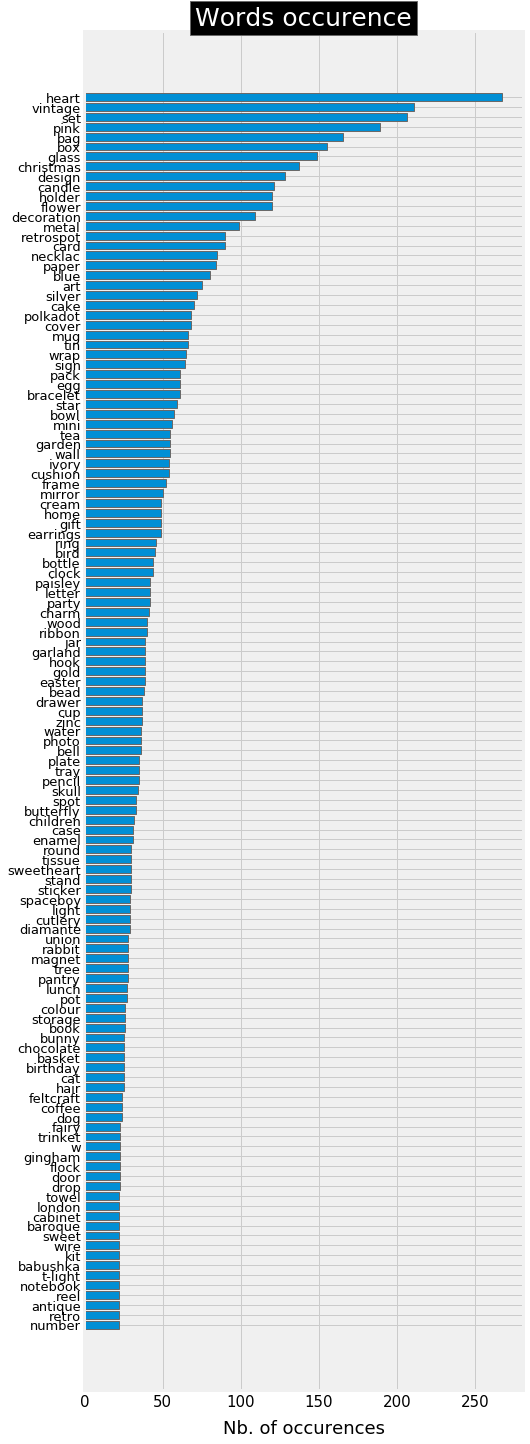

In [56]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### 3.6.2 Defining product categories 

의미없는 단어 지우기

In [57]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
list_products[:10]

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120]]

### 3.6.3 Data encoding

|   | word 1  |  ...  | word j  | ...  | word N  |
|:---:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

![table](table.png)

product = 상품에 있는 Description

$a_ {i, j}$ : 
 - 1 : product $i$의 description이 word $j$를 포함
 - 0 : product $i$의 description이 word $j$를 포함하지 않을 때
 > ### Binary Encoding

In [58]:
list_prods = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_prods)) #list_pords는 다 대문자

In [59]:
list_prods

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [60]:
list_products

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120],
 ['flower', 120],
 ['decoration', 109],
 ['metal', 99],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 84],
 ['art', 75],
 ['silver', 72],
 ['cake', 70],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['wrap', 65],
 ['sign', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 57],
 ['mini', 56],
 ['tea', 55],
 ['garden', 55],
 ['wall', 55],
 ['ivory', 54],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 50],
 ['cream', 49],
 ['home', 49],
 ['gift', 49],
 ['earrings', 49],
 ['ring', 46],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 44],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['wood', 40],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['hook', 39],
 ['gold', 39],
 ['easter', 39],
 ['bead', 38],
 ['drawer', 37],
 ['cup', 37],
 ['zi

#### 상품의 description을 embedding vector로 만들었다.  
여기에 상품 unit price에 따른 Range를 추가한다. 왜냐하면, __상품의 가격(unitprice range)__과 상품의description을 연결시켜보면 더 좋은 정보를 얻을 수 있기 때문이다.  
상품 분류에 따른 상품의 가격대를 파악할 수 있다.

In [61]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_prods):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1  #가격대 range에 대한 binary encoding

In [62]:
X #unit price segmentation을 추가함

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [63]:
print("{:<8} {:<20} \n".format('Range', 'Product의 수') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    Product의 수           
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [64]:
print(X.shape)
X.head()

(3878, 199)


,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 3.6.3 Creating Clusters of Products

상품의 cluster를 구해보자. 사실 binary encoding으로 이루어진 데이터에서 거리를 측정하기 위해서는 __*Hamming's metric*__ 을 이용해야 한다.  
하지만 여기서는 빠르게 분석하기 위해 *Kmeans* 알고리즘을 사용하도록 한다.

그리고 최적의 클러스터의 숫자를 구하기 위해서, silhouette score를 사용해보자.


$$s=\frac{(b-a)}{\text{max}(a,b)}$$


silhouette score : a는 클러스터 안, b는 가장 가까운 클러스트들간의 거리, 클러스터 안의 데이터 포인트 거리 평균이 a, a작고 b는 큰게 중요. best값은 1

In [65]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30) #centroid seed
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.12193090502536758
For n_clusters = 5 The average silhouette_score is : 0.14562442905455303
For n_clusters = 6 The average silhouette_score is : 0.1450621616291374
For n_clusters = 7 The average silhouette_score is : 0.14225706979096936
For n_clusters = 8 The average silhouette_score is : 0.14279977777086983
For n_clusters = 9 The average silhouette_score is : 0.16032906450454232


클러스터의 숫자는 5를 선택하여 silhouette score의 평균이 일정 수준보다 낮아지면 학습을 멈추도록 합니다.  
(inertia보면서 elbow를 확인한 다음 클러스터를 정하는 방법도 존재)

In [66]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


### 3.6.4  Characterizing the content of clusters

In [67]:
pd.Series(clusters).value_counts()

1    1009
2     964
4     673
0     626
3     606
dtype: int64

In [68]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10  

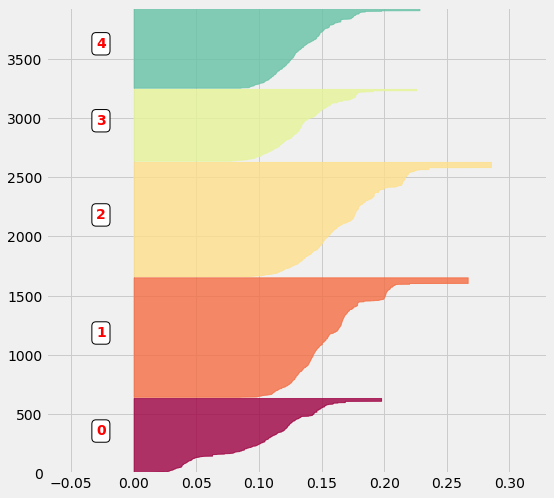

In [69]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

속하는 데이터의 갯수가 면적, 클러스터 안에서, 가장 거리가 먼 값(점수가 작음) 거리가 가까우면 점수가 높음. 몰려있는 비율도 확인 할 수 있음.  
막대 아이스크림 모양이 좋은 것. 클러스터 안의 클러스터도 확인할 수 있음


> **Word Cloud** (Python Word Cloud)확인
- 상품의 Description가지고 만든 클러스터를 눈으로 보고 확인해 보자

In [70]:
_list = pd.DataFrame(list_prods)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = _list.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

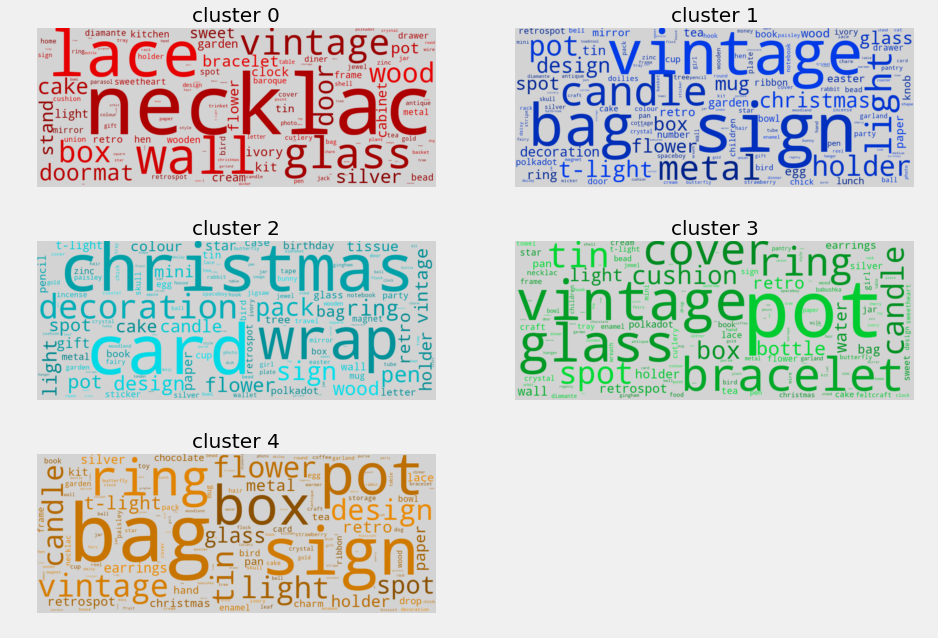

In [71]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster {}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

#### 정성적인 분석 1  
(단어를 클러스터링 한게 아니라, 상품을 클러스터링 한 것이기 때문에 겹치는 단어가 존재함.)  
단어의 등장 빈도수로 클러스터링이 어느정도 되어있다.  
10-12월 자료이기 때문에 christmas도 보임.  

> **Principal Component Analysis** 
- PCA이용 다시한번 체크, 클러스터는 5개로 나왔는데, Principal Component를 뽑은 다음, 클러스터링이 잘 되었는지 시각화 해보자

In [72]:
pca = PCA()
pca.fit(matrix) #matrix가 Binary encoding되어있기 때문에 Scaling이 필요없음
pca_samples = pca.transform(matrix)

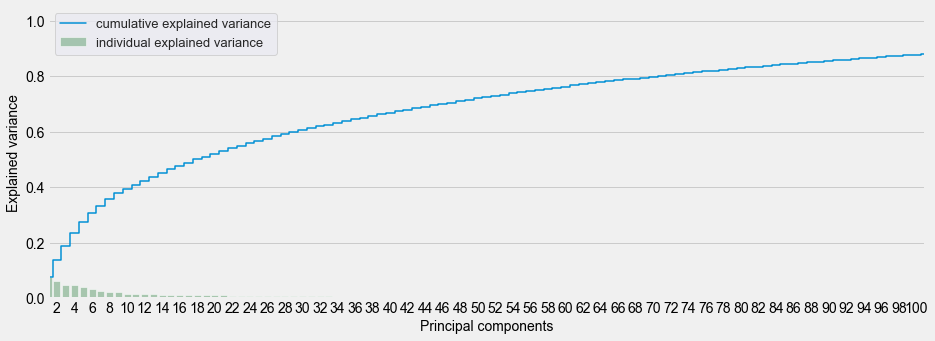

In [73]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

100개 이상이 되어야 전체 분산의 90%를 설명할 수 있는 것을 확인했다. 하지만 시각화를 위해서 50개만 선택.

In [74]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

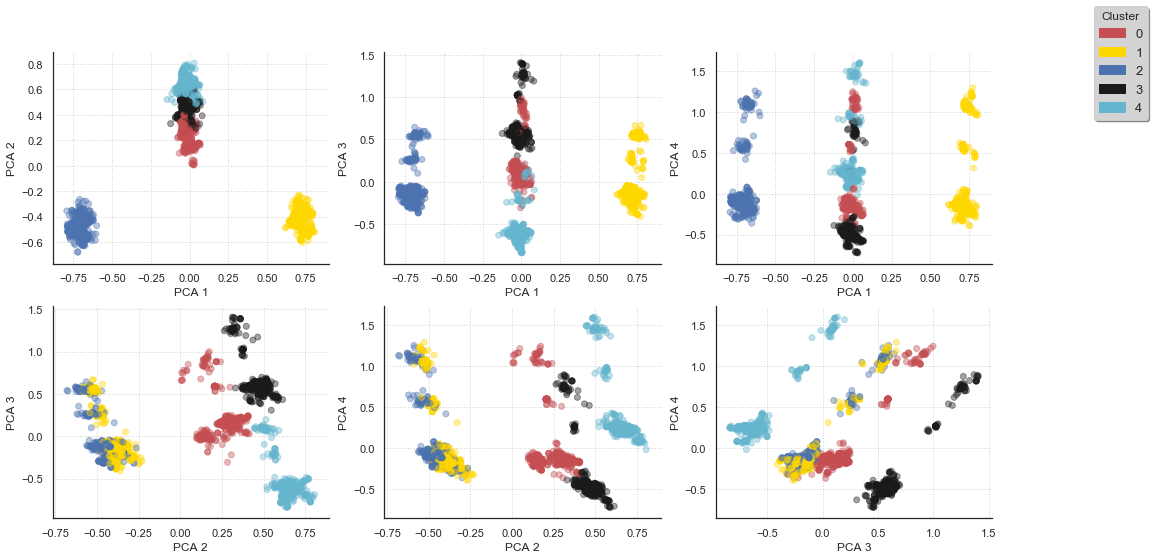

In [75]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i)) #Color handler, 매칭시켜줌

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

#### 정성적인 분석2(시각화)  
PCA 를 통해서 matrix를 5차원으로 줄였다,  
주성분 1,2번이 제일 잘 나눠질 것이다, 왜냐하면 eigen value가 가장 큰 값이기 때문이다.  
각각을 plotting 해본 결과. 그림 1 클러스터가 잘 나눠졌지만, 1번 4번 몇개는 뭉쳐져 있음.  

그림 1을 3차원으로 1,2,3으로 표현했다면 더 잘 나눠졌을 것.

결과가 좋지 않다면 클러스터링을 다시 실시하고, 클러스터링 결과도 좋지 않다면 워드 임베딩을 진행한다.

## 3.7 Customer Categories
- product list와 클러스터를 매칭 시켜주는 작업

In [76]:
corresp = dict()
for key, val in zip (list_prods, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceDate_int,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1291191960000000000,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1291191960000000000,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000,3


In [77]:
for k,v in zip(list_prods,clusters):
    print(k,v)

WHITE HANGING HEART T-LIGHT HOLDER 4
WHITE METAL LANTERN 3
CREAM CUPID HEARTS COAT HANGER 3
KNITTED UNION FLAG HOT WATER BOTTLE 3
RED WOOLLY HOTTIE WHITE HEART. 3
SET 7 BABUSHKA NESTING BOXES 0
GLASS STAR FROSTED T-LIGHT HOLDER 3
HAND WARMER UNION JACK 4
HAND WARMER RED POLKA DOT 1
ASSORTED COLOUR BIRD ORNAMENT 1
POPPY'S PLAYHOUSE BEDROOM  4
POPPY'S PLAYHOUSE KITCHEN 4
FELTCRAFT PRINCESS CHARLOTTE DOLL 3
IVORY KNITTED MUG COSY  1
BOX OF 6 ASSORTED COLOUR TEASPOONS 3
BOX OF VINTAGE JIGSAW BLOCKS  0
BOX OF VINTAGE ALPHABET BLOCKS 0
HOME BUILDING BLOCK WORD 0
LOVE BUILDING BLOCK WORD 0
RECIPE BOX WITH METAL HEART 0
DOORMAT NEW ENGLAND 0
JAM MAKING SET WITH JARS 3
RED COAT RACK PARIS FASHION 3
YELLOW COAT RACK PARIS FASHION 3
BLUE COAT RACK PARIS FASHION 3
BATH BUILDING BLOCK WORD 0
ALARM CLOCK BAKELIKE PINK 3
ALARM CLOCK BAKELIKE RED  3
ALARM CLOCK BAKELIKE GREEN 3
PANDA AND BUNNIES STICKER SHEET 2
STARS GIFT TAPE  2
INFLATABLE POLITICAL GLOBE  2
VINTAGE HEADS AND TAILS CARD GAME  1
SET/2

LOVE HEART NAPKIN BOX  3
SKULLS GREETING CARD 2
HANGING CHICK  YELLOW DECORATION 1
SET OF 72 SKULL PAPER  DOILIES 1
SET OF 36 PAISLEY FLOWER DOILIES 1
SPACEBOY GIFT WRAP 2
BLUE GLASS CHUNKY CHARM BRACELET 0
BLACK+WHITE NECKLACE W TASSEL 0
AMBER CHUNKY GLASS+BEAD NECKLACE 0
POPPY'S PLAYHOUSE LIVINGROOM  4
GINGHAM ROSE WRAP 2
12 PENCILS TALL TUBE POSY 2
12 COLOURED PARTY BALLOONS 2
PINK FLOWER CROCHET FOOD COVER 3
FLOWER VINE RAFFIA FOOD COVER 3
FOOD/DRINK SPONGE STICKERS 2
PINK HEART SHAPE PHOTO FRAME 1
LILAC DIAMANTE PEN IN GIFT BOX 0
SILVER DIAMANTE PEN IN GIFT BOX 0
BLUE JUICY FRUIT PHOTO FRAME 4
GREEN JUICY FRUIT PHOTO FRAME 4
GLITTER BUTTERFLY CLIPS 4
ASSORTED CREEPY CRAWLIES 2
VINTAGE UNION JACK MEMOBOARD 0
BASKET OF FLOWERS SEWING KIT 2
ANTIQUE SILVER TEA GLASS ETCHED 1
FAMILY ALBUM WHITE PICTURE FRAME 0
WRAP PINK FAIRY CAKES  2
BABY BOOM RIBBONS  1
ENAMEL WASH BOWL CREAM 3
LOCAL CAFE MUG 1
DIAMANTE BOW BROOCH BLACK COLOUR 0
DIAMANTE BOW BROOCH GREEN COLOUR 0
DIAMANTE BOW BROOCH 

ASSORTED TUTTI FRUTTI HEART BOX 1
POLYESTER FILLER PAD 65CMx65CM 3
ASSORTED TUTTI FRUTTI NOTEBOOK 4
FRENCH BLUE METAL DOOR SIGN 6 1
SMALL RED RETROSPOT WINDMILL 1
HAND TOWEL PALE BLUE W FLOWERS 3
BLUE ORGANDY ROUND LAMPSHADE W BEA 2
WHITE AND BLUE CERAMIC OIL BURNER 1
PAPER CHAIN KIT SKULLS  4
PINK FAIRY CAKE CUSHION COVER 3
GREEN POP ART MAO CUSHION COVER  2
HEART SHAPED MIRROR 1
GOLD WASHBAG 4
PURPLE PAPER PARASOL 4
FRENCH GARDEN SIGN BLUE METAL 1
BROCANTE COAT RACK 0
WHITE GOOSE FEATHER CHRISTMAS TREE  4
PINK PAISLEY ROSE GIFT WRAP 2
WOODLAND  STICKERS 2
SILVER TEDDY BEAR 3
PSYCHEDELIC WALL THERMOMETER 1
GARLAND WITH HEARTS AND BELLS 3
MAGIC DRAWING SLATE BUNNIES  2
CERAMIC BIRDHOUSE CRESTED TIT SMALL 4
WRAP FOLK ART 2
SILVER JEWELLED MIRROR TRINKET TRAY 0
4 LILY  BOTANICAL DINNER CANDLES 4
ROSE DU SUD WASHBAG  0
ROSE DU SUD COSMETICS BAG 3
GROW A FLYTRAP OR SUNFLOWER IN TIN 1
CAMOUFLAGE EAR MUFF HEADPHONES 0
BLUE POLKADOT EGG CUP  2
VINTAGE BEAD PINK EVENING BAG 1
ENGLISH ROSE SCEN

EGG FRYING PAN PINK  4
EGG FRYING PAN MINT  4
SPACE BOY CHILDRENS CUP 1
DOLLY GIRL CHILDRENS CUP 1
DOLLY GIRL CHILDRENS BOWL 1
SPACEBOY CHILDRENS BOWL 1
RED VINTAGE SPOT BEAKER 2
ROSE DU SUD CUSHION COVER  3
VINTAGE  2 METER FOLDING RULER 1
BISCUIT TIN VINTAGE LEAF 4
CANNISTER VINTAGE LEAF DESIGN 1
VINTAGE RED ENAMEL TRIM MUG  1
VINTAGE RED ENAMEL TRIM PLATE 1
VINTAGE RED TRIM ENAMEL BOWL  1
VINTAGE DONKEY TAIL GAME  3
BISCUIT TIN VINTAGE CHRISTMAS 4
GLASS APOTHECARY BOTTLE PERFUME 3
GLASS APOTHECARY BOTTLE ELIXIR 3
DRAWER KNOB CERAMIC IVORY 1
CROCHET DOG KEYRING 1
GLASS  SONGBIRD STORAGE JAR 0
DRAWER KNOB CRACKLE GLAZE IVORY 1
DRAWER KNOB CRACKLE GLAZE BLUE 1
DRAWER KNOB CRACKLE GLAZE PINK 1
DRAWER KNOB CRACKLE GLAZE GREEN 1
DRAWER KNOB CERAMIC RED 1
DRAWER KNOB CERAMIC BLACK 1
GLASS APOTHECARY BOTTLE TONIC 3
DONKEY TAIL GAME  3
TRANSPARENT ACRYLIC TAPE DISPENSER 1
 TOADSTOOL BEDSIDE LIGHT  0
JUMBO BAG 50'S CHRISTMAS  4
GOLD FABRIC MIRROR 2
DOORKNOB CRACKED GLAZE IVORY 1
DOORKNOB CRAC

### 3.7.1 Grouping products

**categ_N** (with $ N \in [0: 4]$)을 생성한다(5개). 각각은 해당 Transaction의 구매금액에 대한 category의 one_hot 개념이다.
- 카테고리 몇번에 구매금액이 몇이다

In [78]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].head()

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.00,15.3
1,536365,WHITE METAL LANTERN,3,0.0,0.0,0.0,20.34,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.0,0.0,22.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.0,0.0,20.34,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.0,20.34,0.0


데이터를 하나로 모은다.

In [79]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

In [80]:
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

In [81]:
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346,541431,0.00,0.00,0.0,0.00,0.00,0.00
1,12347,537626,711.79,124.44,187.2,23.40,293.35,83.40
2,12347,542237,475.39,38.25,130.5,84.34,169.20,53.10
3,12347,549222,636.25,38.25,330.9,81.00,115.00,71.10
4,12347,556201,382.52,19.90,74.4,41.40,168.76,78.06


In [82]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True).head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,187.2,23.40,293.35,83.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,38.25,130.5,84.34,169.20,53.10,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,38.25,330.9,81.00,115.00,71.10,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,19.90,74.4,41.40,168.76,78.06,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,136.05,109.7,61.30,158.16,119.70,2011-08-02 08:48:00.000000000


### 3.7.2 Separation of Data Over time

모델링의 목적은 사용자의 행동을 분석하여, 그 다음 사용자의 행동을 예측하는 하는 것이다. 따라서, 현 데이터의 10개월 치의 데이터만 학습에 사용하고, 2개월 치의 데이터를 테스트에 사용해서 성능을 측정해본다.

(10개월 데이터, 2개월 데이터 나눴고, 10개월로 학습해서 2개월을 예측할 것)

In [83]:
print(basket_price['InvoiceDate'].min(), basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


In [84]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [85]:
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,187.2,23.40,293.35,83.40,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,38.25,130.5,84.34,169.20,53.10,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,38.25,330.9,81.00,115.00,71.10,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,19.90,74.4,41.40,168.76,78.06,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,136.05,109.7,61.30,158.16,119.70,2011-08-02 08:48:00.000000000


### 3.7.3 Customer Order
- 'count','min','max','mean','sum'을 실시해서 컬럼 생성
- FirstPurchse, LastPurchase 생성

In [86]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    # 각 유저의 Basket_price sum 대비 각 카테고리별로 얼마의 돈을 사용하였는가를 비율로 나타낸다.
    transactions_per_user.loc[:,col]= basket_price.groupby(by=['CustomerID'])[col].sum()/transactions_per_user['sum']*100

In [87]:
transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True).head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,12.787815,29.836681,10.442659,32.408290,14.524555
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,38.016069,0.000000,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,11.692584,0.000000,27.900718
3,12352,6,144.35,840.30,345.663333,2073.98,67.534402,12.892120,0.491808,15.711338,3.370331
4,12353,1,89.00,89.00,89.000000,89.00,67.078652,13.033708,0.000000,0.000000,19.887640


__FirstPurchase__, __LastPurchase__ 를 정의한다.

In [88]:
last_date = basket_price['InvoiceDate'].max().date() #평균 주문날의 최대값

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate'] #마지막 주문에서부터 마지막 구매까지
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate'] #첫 주문일부터 마지막 구매까지

transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,12.787815,29.836681,10.442659,32.408290,14.524555,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,38.016069,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,11.692584,0.000000,27.900718,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,67.534402,12.892120,0.491808,15.711338,3.370331,2,226
4,12353,1,89.00,89.00,89.000000,89.00,67.078652,13.033708,0.000000,0.000000,19.887640,134,134


#### 1개의 Transaction만 가지고 있는 사용자들은 전체의 40% 정도이다.

In [89]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("{:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

1445/3608  (40.05%)


## 3.8 Creation of customers categories

Customer를 카테고리로 나누어 보겠습니다.

### 3.8.1 Data encoding

In [90]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix() #선택된 칼럼들을 matrix화

In [91]:
matrix[:1]

array([[  5.        , 382.52      , 711.79      , 558.172     ,
         12.78781451,  29.83668117,  10.44265925,  32.40828992,
         14.52455516]])

In [92]:
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix) #PCA를 위한 Scaling 위에서는 binary였기때문에 필요 없었음

In [93]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

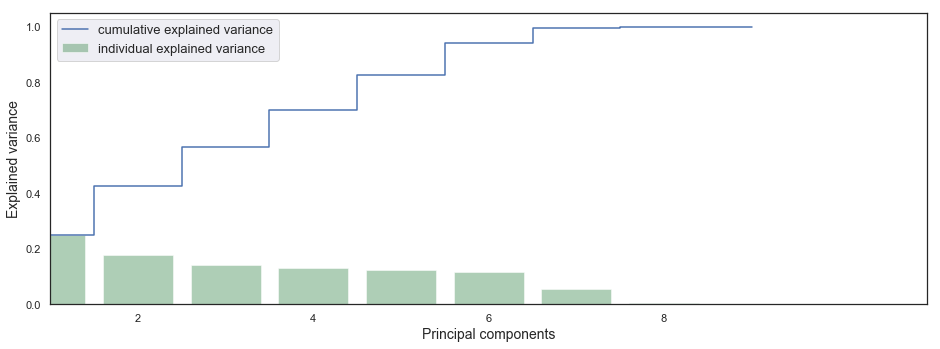

In [94]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

### 3.8.2 Creation of customer categories

- Silhouette score를 사용하여 best score를 찾습니다.
- 클러스터 11개?

In [95]:
n_clusters = 11 #임의로 넣은 것
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix) #kmeans로 예측한 cluster label
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Avg silhouett score: {:<.3f}'.format(silhouette_avg))

Avg silhouett score: 0.218


In [96]:
clusters_clients

array([1, 7, 7, ..., 1, 1, 7], dtype=int32)

In [97]:
# 각 클러스터에 속한 사용자의 수를 나타냅니다.
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['num_clients']).T

,1,4,7,10,2,0,5,8,6,3,9
num_clients,1455,508,462,290,286,231,187,159,12,10,8


> **Report via the PCA**

In [98]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

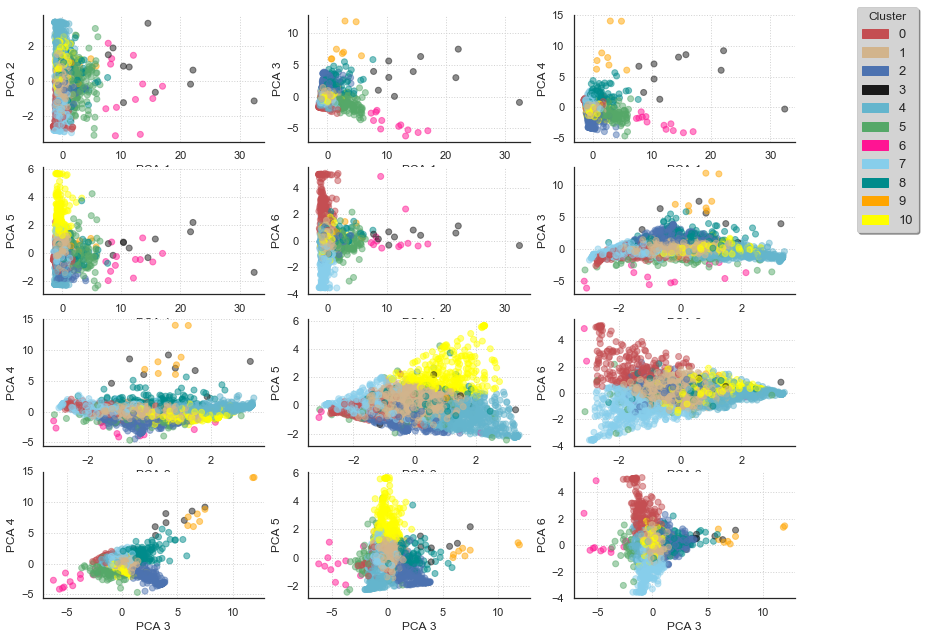

In [99]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout() ##cluster 11개는 그닥...

> __Silhouette Score__

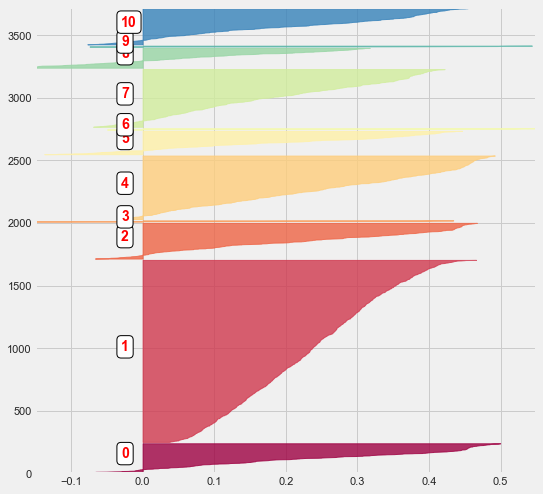

In [100]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

conponent갯수 바꿔가면서 실루엣 계수를 살펴보고 갯수를 정해볼 수도 있다.

**Customers morphotype**

각 클러스터가 disjoint 한지 알아보자. 각 클러스터에 있는 사용자의 특징을 이해해보자.

In [101]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,12.787815,29.836681,10.442659,32.408290,14.524555,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,38.016069,0.000000,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,11.692584,0.000000,27.900718,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,67.534402,12.892120,0.491808,15.711338,3.370331,2,226
4,12353,1,89.00,89.00,89.000000,89.00,67.078652,13.033708,0.000000,0.000000,19.887640,134,134


In [102]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [103]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

In [104]:
test.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,,
10.0,inf,2.131034,202.62331,335.110552,262.189665,649.416207,15.323963,13.455483,6.326378,51.418763,13.528824,110.310345,170.196552,290


In [105]:
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


In [106]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0]) #45라는 기준은 임의로 정함

list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,4.0,2.614173,199.237935,345.103130,261.898516,709.880415,62.325559,11.079477,4.775956,10.956740,10.873377,508
1,7.0,2.463203,212.448442,329.339742,267.238692,675.946842,9.533703,57.162251,12.778250,7.710028,12.818989,462
2,0.0,2.199134,193.774026,317.699913,247.165261,582.228312,7.249538,18.052858,57.570041,6.026141,11.101421,231
3,10.0,2.131034,202.623310,335.110552,262.189665,649.416207,15.323963,13.455483,6.326378,51.418763,13.528824,290
4,2.0,2.580420,209.531993,373.666434,287.088068,810.038007,10.043807,14.761980,6.951149,6.873025,61.370039,286
5,1.0,3.213746,219.872118,454.787114,329.364203,1070.278351,20.728874,25.600649,13.971090,17.481363,22.222098,1455
6,5.0,1.684492,1045.404171,1361.886048,1190.395353,2060.554444,22.751131,26.465423,12.226722,17.154671,21.402414,187
7,6.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,28.513409,20.102624,22.890736,15.171169,13.322062,12
8,8.0,17.622642,85.079119,1543.278679,567.718412,9404.369623,21.781717,24.112314,12.383224,16.057292,25.685160,159
9,9.0,87.125000,20.862500,2643.812500,456.526689,37313.235000,24.794942,25.165035,11.477885,13.979829,24.604929,8


In [107]:
#merged_df.head()
merged_df[['count','min','max','mean','sum','categ_0','categ_1','categ_2','categ_3','categ_4','size','cluster']].groupby(['cluster']).sum()

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
cluster,,,,,,,,,,,
0.0,2.199134,193.774026,317.699913,247.165261,582.228312,7.249538,18.052858,57.570041,6.026141,11.101421,231
1.0,3.213746,219.872118,454.787114,329.364203,1070.278351,20.728874,25.600649,13.971090,17.481363,22.222098,1455
2.0,2.580420,209.531993,373.666434,287.088068,810.038007,10.043807,14.761980,6.951149,6.873025,61.370039,286
3.0,23.200000,415.148000,17158.271000,4853.774161,87883.059000,29.638970,22.089309,7.172572,18.726071,22.373077,10
4.0,2.614173,199.237935,345.103130,261.898516,709.880415,62.325559,11.079477,4.775956,10.956740,10.873377,508
5.0,1.684492,1045.404171,1361.886048,1190.395353,2060.554444,22.751131,26.465423,12.226722,17.154671,21.402414,187
6.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,28.513409,20.102624,22.890736,15.171169,13.322062,12
7.0,2.463203,212.448442,329.339742,267.238692,675.946842,9.533703,57.162251,12.778250,7.710028,12.818989,462
8.0,17.622642,85.079119,1543.278679,567.718412,9404.369623,21.781717,24.112314,12.383224,16.057292,25.685160,159


**Customers morphology**

(https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave-read-this) 에서 참고

In [108]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid(False)
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


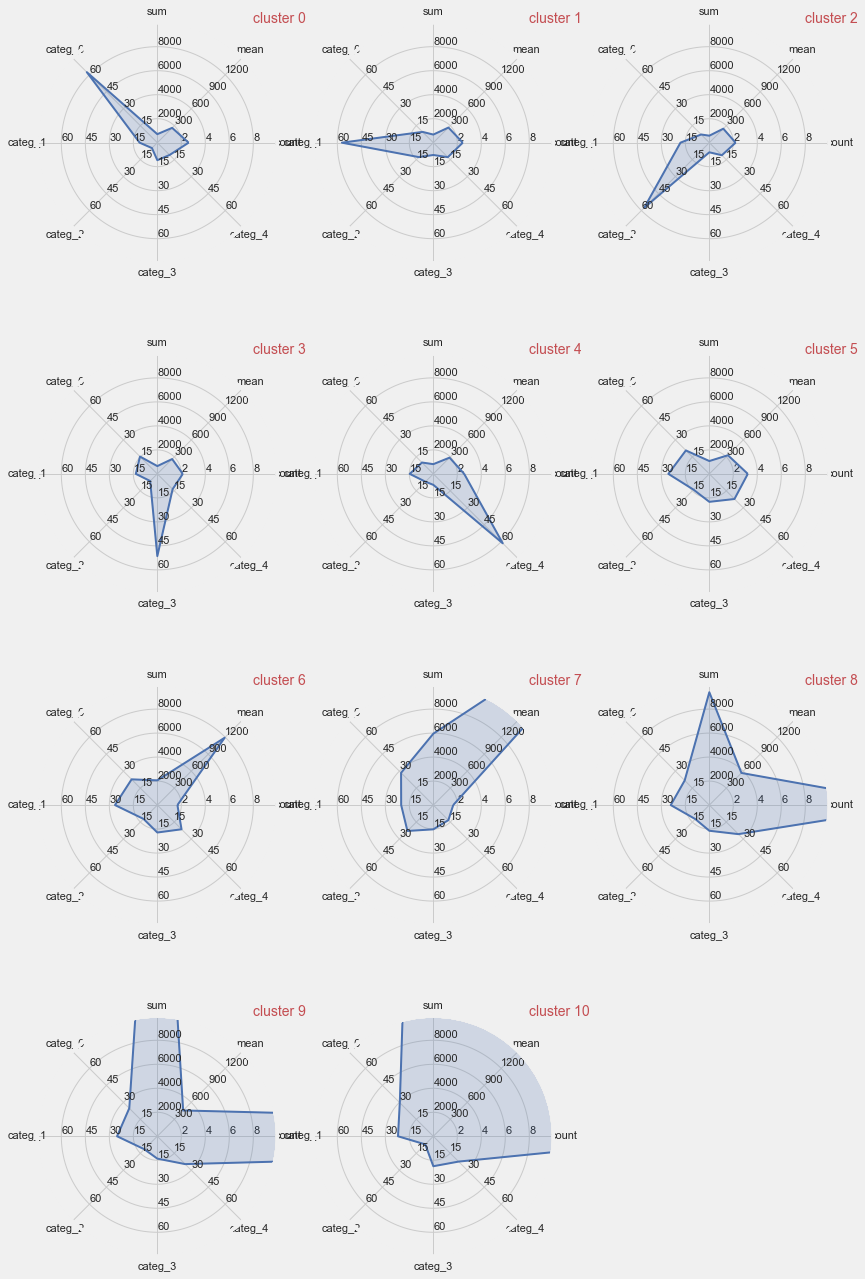

In [109]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 

모양이 비슷한 게 많이 보인다

## 4. Classification of customers
- 11개의 클러스터는 시각화용, 다른 정보가 있는지 확인용
- 분류문제는 5개의 클러스터링 점수가 더 좋았고, 시각화 결과도 좋았기 때문에 5개의 cluster category를 사용한다

In [110]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Accuracy: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

In [111]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [112]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=42)

In [113]:
X_train.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
2530,34.000,100.000000,0.000000,0.000000,0.000000,0.000000
1113,480.910,21.095423,28.329625,13.437026,20.492400,16.645526
2893,420.595,23.514307,19.858772,16.801198,26.545727,13.279996
790,388.115,46.558365,9.043711,6.258454,19.201783,18.937686
3006,295.628,5.845184,30.749455,24.243306,17.559230,21.602825


In [114]:
Y_train.head()

2530    4
1113    1
2893    1
790     4
3006    1
Name: cluster, dtype: int32

### 4.1 Support Vector Machine Classifier (SVC)
#### 4.1.1 학습

In [115]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [116]:
svc.grid_fit(X = X_train, Y = Y_train)

/Users/sanghyub/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [117]:
svc.grid_predict(X_test, Y_test)

Accuracy: 79.64 % 


#### 4.1.2 성능평가

성능평가를 위해 Confusion matrix를 사용하겠습니다.

In [118]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


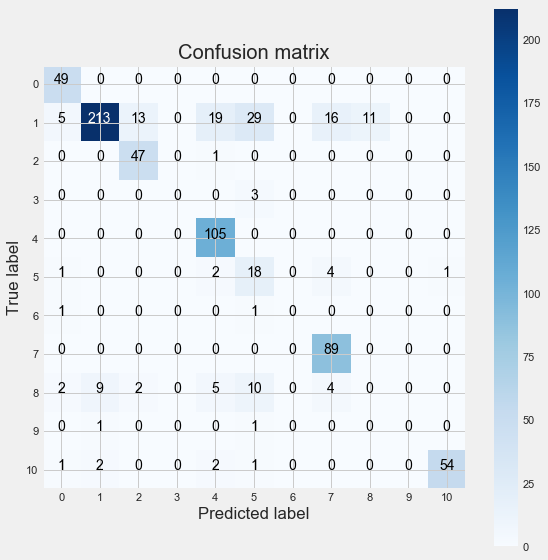

In [119]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

### 4.2 Random Forest

In [120]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test) 

Accuracy: 90.72 % 


## 결론
- 모델링에 들어간 Feature로 데이터 셋을 구성해서 RandomForest로 Predict하면
- 약 90%의 정확도로 고객 Segmentation을 할 수 있다.